**Problem statement**<br>
We are provided 7 images of wood surfaces/textures, and the objective is to identify segments of the image that contain anomalies such as knots. 

**Rationale for, and description of, implemented solution**<br>
The images are mostly smooth or "normal" wood, with a few patches of anomalies in each. Thus the anomalies are visually distinct from the majority of the image. This context lends itself well to the use of autoencoders for anomaly detection. An autoencoder model can be thought of as constituting two components: an encoder and a decoder, sequentially. For each data point inputted to the model, the encoder learns a low-dimensional, latent representation of the features. The data is thus enters a bottleneck through which a smaller amount of information can pass than was originally provided to the model. The decoder, in turn, attempts to recreate the original image based on this latent representation. Through training, the encoder learns to extract the most important features of the data that will allow the decoder to reconstruct an image that is as similar as possible to the original. <br><br>
The approach implies that anomalous data are geometrically more distant from normal data, thereby making them more difficult for the decoder to reconstruct. Thus, outputs with higher reconstruction error can be labelled anomalous. 

![autoencoder diagram](autoencoder.png "https://www.compthree.com/blog/autoencoder/")
*Source: https://www.compthree.com/blog/autoencoder/*

**Steps taken in the notebook**<br>
1. Load data, including separating each into patches that will be analysed individually to look for anomalies. 
1. Build the autoencoder model
1. Train the model
1. Visual evaluation of the model performance
1. Discussion of conclusion and future directions

**Note on train/test splits**<br>
Usually, a train/validation/test split is used in machine learning model development and evaluation. However, this task calls for unsupervised learning, as there are no labels attributed to the images or patches used to train the model. Thus I reasoned that there was little logic in performing a train test split. Furthermore, in a production environment, it would be possible to train the autoencoder model on the novel data before applying the reconstruction thresholding. 

**Imports**

In [1]:
import jupyter_black

jupyter_black.load(lab=False)

import copy
import os
from collections import defaultdict
from operator import itemgetter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

<IPython.core.display.Javascript object>

**Set up global variables**

In [2]:
# Folder containing data
DATA_PATH = "data"
PATCH_DIM = (
    64,
    64,
    3,
)  # Dimensions of patch size; try first with keeping the colour channels
BATCH_SIZE = 32

**Load data, separating into patches**

In [3]:
# Get image paths
img_fpaths = [
    os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) if f.endswith(".jpg")
]

# Save patches in a dictionary
img_patch_dict = {}
for fpath in img_fpaths:
    # Load image as an array
    img = np.array(cv2.imread(fpath))

    # Resize image so it can be divided into patches
    img_dim = [(img.shape[i] // PATCH_DIM[i]) * PATCH_DIM[i] for i in (1, 0)]
    img = cv2.resize(img, img_dim)

    # Use patchify library to split into patches that can be re-assembled if needed
    patches = patchify(img, PATCH_DIM, step=PATCH_DIM[0])

    # Re-arrange patches into list that can later be interpreted by data loader
    img_patches = []
    for h in range(patches.shape[0]):
        for w in range(patches.shape[1]):
            img_patches.append(patches[h, w, 0])

    # Place in dictionary
    img_patch_dict[fpath] = img_patches

for k, v in img_patch_dict.items():
    print(f"{len(v)} patches created for image file {k}")

1200 patches created for image file data/2021-04-07 21_37_18_exai_rpi_001_58.jpg
1200 patches created for image file data/2021-04-07 21_45_00_exai_rpi_004_176.jpg
1200 patches created for image file data/2021-04-07 21_36_40_exai_rpi_004_51.jpg
1200 patches created for image file data/2021-04-07 21_43_40_exai_rpi_004_156.jpg
1200 patches created for image file data/2021-04-07 21_39_20_exai_rpi_004_91.jpg
1200 patches created for image file data/2021-04-07 21_40_10_exai_rpi_001_101.jpg
1200 patches created for image file data/2021-04-07 21_39_06_exai_rpi_001_85.jpg


**Create train/val/test split**

We'll be building our model in torch, so make a torch-friendly loader.

In [4]:
# Custom Dataset class interpretable by torch dataloader
class WoodDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        return self.transform(x)

    def __len__(self):
        return len(self.data)


# Define transform
transform = transforms.Compose([transforms.ToTensor()])

# Make dataset
dataset = WoodDataset(
    data=[x for i in itemgetter(*img_fpaths)(img_patch_dict) for x in i],
    transform=transform,
)

# Make dataloader - iterative class that feeds images into the model during training
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

**Build autoencoder model**

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder:
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)

        # Pooling:
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder:
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        # Encoder
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))

        # Low-D representation:
        x = self.pool(x)

        # Decoder
        x = nn.functional.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))

        return x


# Instantiate the model
model = Autoencoder()
print(model)

Autoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


**Define training configs**

In [6]:
# Define loss function
loss_fn = nn.MSELoss()

# Define optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

**Train the model on the training data**

In [7]:
# Set number of epochs for training
n_epochs = 100

for epoch in tqdm(range(n_epochs)):
    # Initialise training loss
    train_loss = 0.0

    for data in dataloader:
        # Set tensor gradients to zero
        optim.zero_grad()

        # Compute predicted outputs
        outputs = model(data)

        # Get loss
        loss = loss_fn(outputs, data)

        # Compute gradient wrt loss and network parameters
        loss.backward()

        # Parameter update
        optim.step()

        # Track loss
        train_loss += loss.item() * data.size(0)

    # Print average loss
    train_loss = train_loss / len(dataloader)

    if (epoch % 10 == 0) | (epoch == n_epochs - 1):
        print("Epoch: {} \tTraining Loss: {:.6f}".format(epoch, train_loss))

  1%|▍                                          | 1/100 [00:08<13:57,  8.46s/it]

Epoch: 0 	Training Loss: 0.459400


 11%|████▌                                     | 11/100 [01:31<12:14,  8.25s/it]

Epoch: 10 	Training Loss: 0.058544


 21%|████████▊                                 | 21/100 [02:55<11:04,  8.42s/it]

Epoch: 20 	Training Loss: 0.043852


 31%|█████████████                             | 31/100 [04:19<09:41,  8.43s/it]

Epoch: 30 	Training Loss: 0.039950


 41%|█████████████████▏                        | 41/100 [05:44<08:18,  8.44s/it]

Epoch: 40 	Training Loss: 0.038108


 51%|█████████████████████▍                    | 51/100 [07:08<06:53,  8.43s/it]

Epoch: 50 	Training Loss: 0.036937


 61%|█████████████████████████▌                | 61/100 [08:32<05:28,  8.42s/it]

Epoch: 60 	Training Loss: 0.036183


 71%|█████████████████████████████▊            | 71/100 [09:57<04:04,  8.42s/it]

Epoch: 70 	Training Loss: 0.035110


 81%|██████████████████████████████████        | 81/100 [11:21<02:40,  8.44s/it]

Epoch: 80 	Training Loss: 0.034311


 91%|██████████████████████████████████████▏   | 91/100 [12:46<01:16,  8.46s/it]

Epoch: 90 	Training Loss: 0.033304


100%|█████████████████████████████████████████| 100/100 [14:03<00:00,  8.43s/it]

Epoch: 99 	Training Loss: 0.032322


**Visualise the reconstruction performance on some validation patches**

Here we can see the extent to which the autoencoder is able to reconstruct an original patch based on its latent representation. We should see that the reconstructed image is quite similar to the original, which will tell us that training worked as expected.

I used these cells to manually fine-tune the reconstruction error threshold. 

In [8]:
def add_red_overlay(img, alpha=0.3):
    overlay = cv2.rectangle(copy.deepcopy(img), (0, 0), img.shape[:2], (200, 0, 0), -1)
    img_new = cv2.addWeighted(overlay, alpha, copy.deepcopy(img), 1 - alpha, 1)
    return img_new


def visualise_anomalies(
    image_to_patchify,
    patch_dim,
    model,
    reconstruction_error_threshold=0.002,
    loss_fn=nn.MSELoss(),
    transform=transforms.Compose([transforms.ToTensor()]),
):
    # Patchify
    patches = patchify(image_to_patchify, PATCH_DIM, step=PATCH_DIM[0])

    # Re-arrange patches into list that can later be interpreted by data loader
    for h in range(patches.shape[0]):
        for w in range(patches.shape[1]):
            # Extract desired patch
            input_patch = patches[h, w, 0]

            # Get reconstruction from model
            reconstruction = model(transform(input_patch))

            # Get reconstruction error
            reconstruction_error = loss_fn(reconstruction, transform(input_patch))

            # If error > threshold, overlay a red rectangle
            if reconstruction_error >= reconstruction_error_threshold:
                patch = patches[h, w, 0]
                patches[h, w, 0] = add_red_overlay(patch)

    return unpatchify(patches, image_to_patchify.shape)

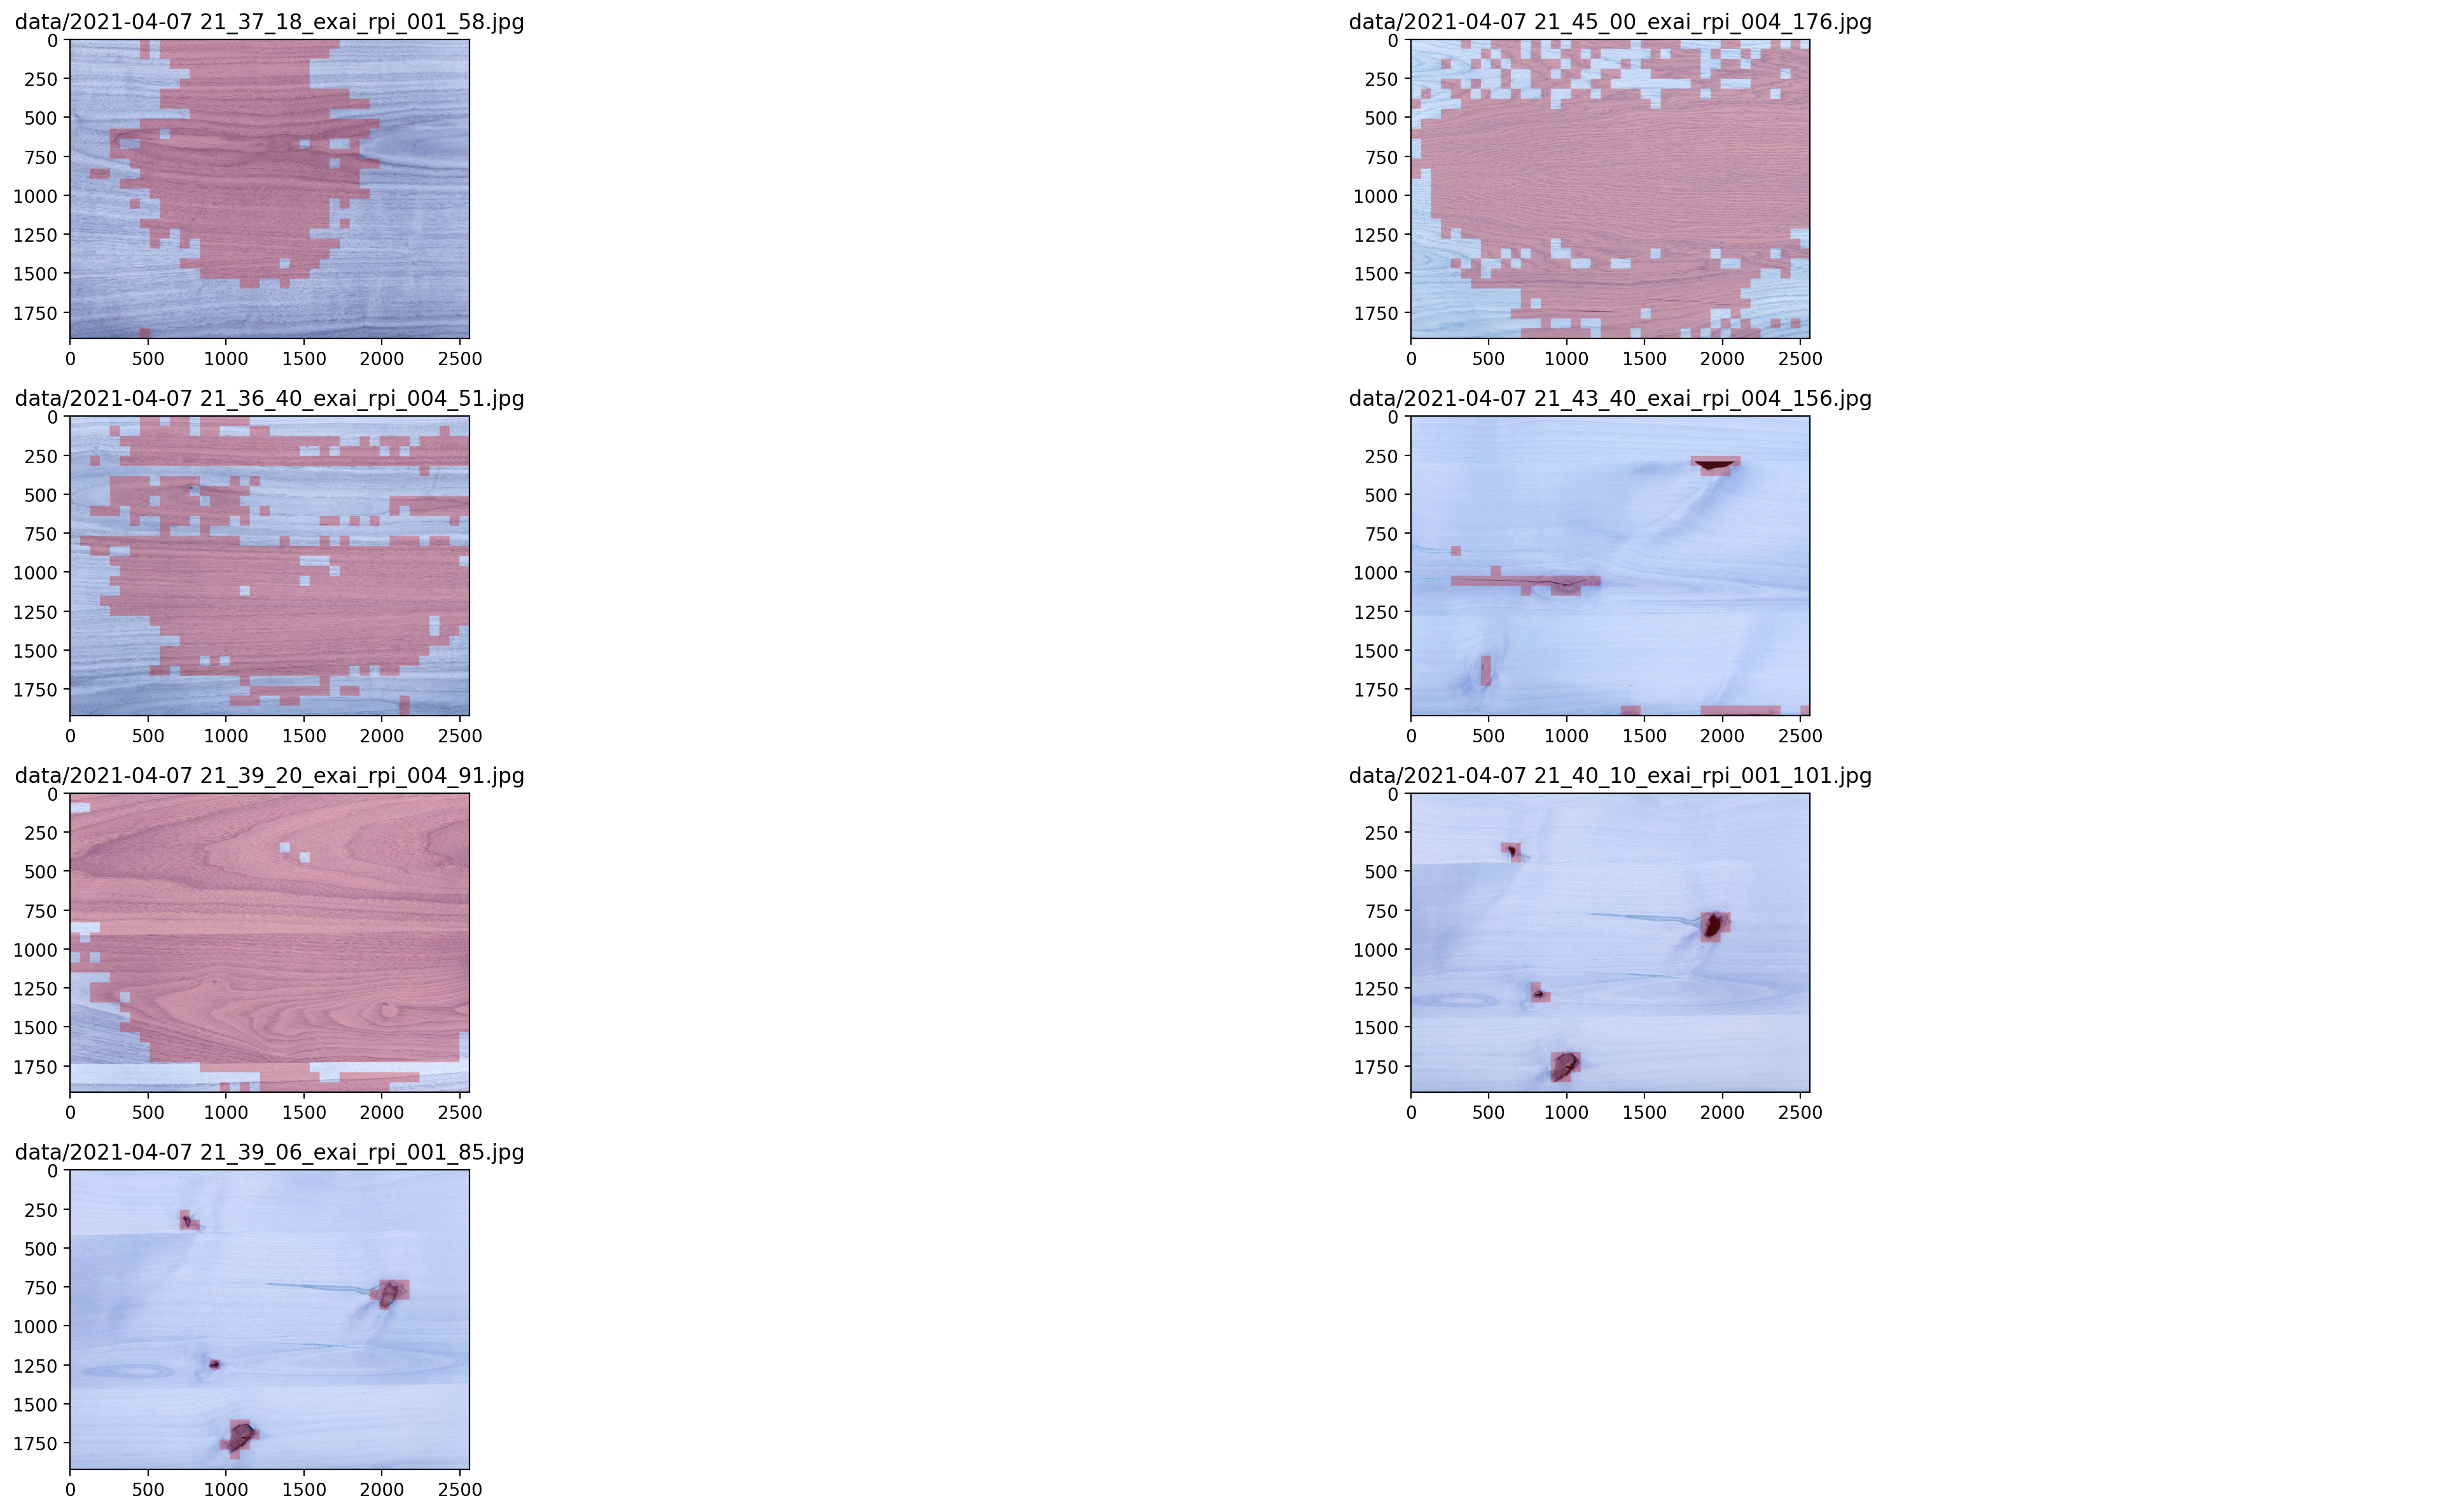

In [11]:
reconstruction_error_thresh = 0.001

f, ax = plt.subplots(4, 2, figsize=(24, 12))
ax = ax.ravel()

for ax_idx, path in enumerate(img_fpaths):
    # Load image as an array
    img = np.array(cv2.imread(path))

    # Resize image
    img_dim = [(img.shape[i] // PATCH_DIM[i]) * PATCH_DIM[i] for i in (1, 0)]
    img = cv2.resize(img, img_dim)

    # Use our function to construct an image with shaded patches labelling anomalies
    img_ = visualise_anomalies(
        image_to_patchify=img,
        patch_dim=PATCH_DIM,
        model=model,
        reconstruction_error_threshold=reconstruction_error_thresh,
        loss_fn=loss_fn,
        transform=transform,
    )

    # Display the image on the axes
    ax[ax_idx].imshow(img_)
    ax[ax_idx].set_title(path)

# Final figure formatting
ax[-1].axis("off")
f.tight_layout()
f.set_dpi(200)

**Conclusions**

The cell above shows that with a reconstrunction error threshold (RET) of around 0.001 mean squared error (MSE), the autoencoder model has good performance in detecting knots in 3 of the images. These images contain very dark knots that contrast strongly with the rest of the wood grain, whereas the images in which the anomaly detection model works less well don't have these features. Rather, they have more constrasting normal grain.

Increasing the RET did not resolve the problem (see below), suggesting that the problem lies in the autoencoder's ability to either encode the image or decode the latent representation. To investigate this I made a duplicate notebook in which I only trained the model on images 58, 51, 91, and 176 (poor performance images), to test the hypothesis that in this notebook the model was attempting to learn too broad a range of features. In doing so I was able to detect small cracks in one of the images. However, clearly the problem is unsolved this should be the main target for model improvement.

**Future directions**

1. Ideally, the autoencoder would be trained exclusively on normal (non-anomalous) data, so that it doesn't learn representations of anomalous data. Given more time I would separate the patches manually and do this. In this instance it would also be necessary to do a train/test split, leaving some of the normal patches in the test set.
1. Using a larger model, for example one that had been pre-trained on vision tasks, could leverage transfer learning.
1. Explore different dimensionalities for pooling layer in network (corresponds to dimensionality of latent representation). The fact that the autoencoder performed poorly when reconstructing some of the images that had more contrastive textures suggests that a higher dimensionality permitted in the autoencoder bottleneck might permit more relevant information to be transmitted to the decoder for improved reconstruction.
1. Data augmentation such as rotation/contrast modification, or using patch shapes that adhere more to grain patterns.
1. Expand the dataset; although the problem states that a small dataset is provided on purpose, in this specific instances, publicly available datasets of wood grain textures are available and would be worth considering adding to the training data.
1. There are also many other sub-image anomaly detection methodologies out there such as [PaDiM](https://arxiv.org/abs/2011.08785) and [SPADE](https://arxiv.org/abs/2005.02357) which might be applicable here but take slightly longer to implement.

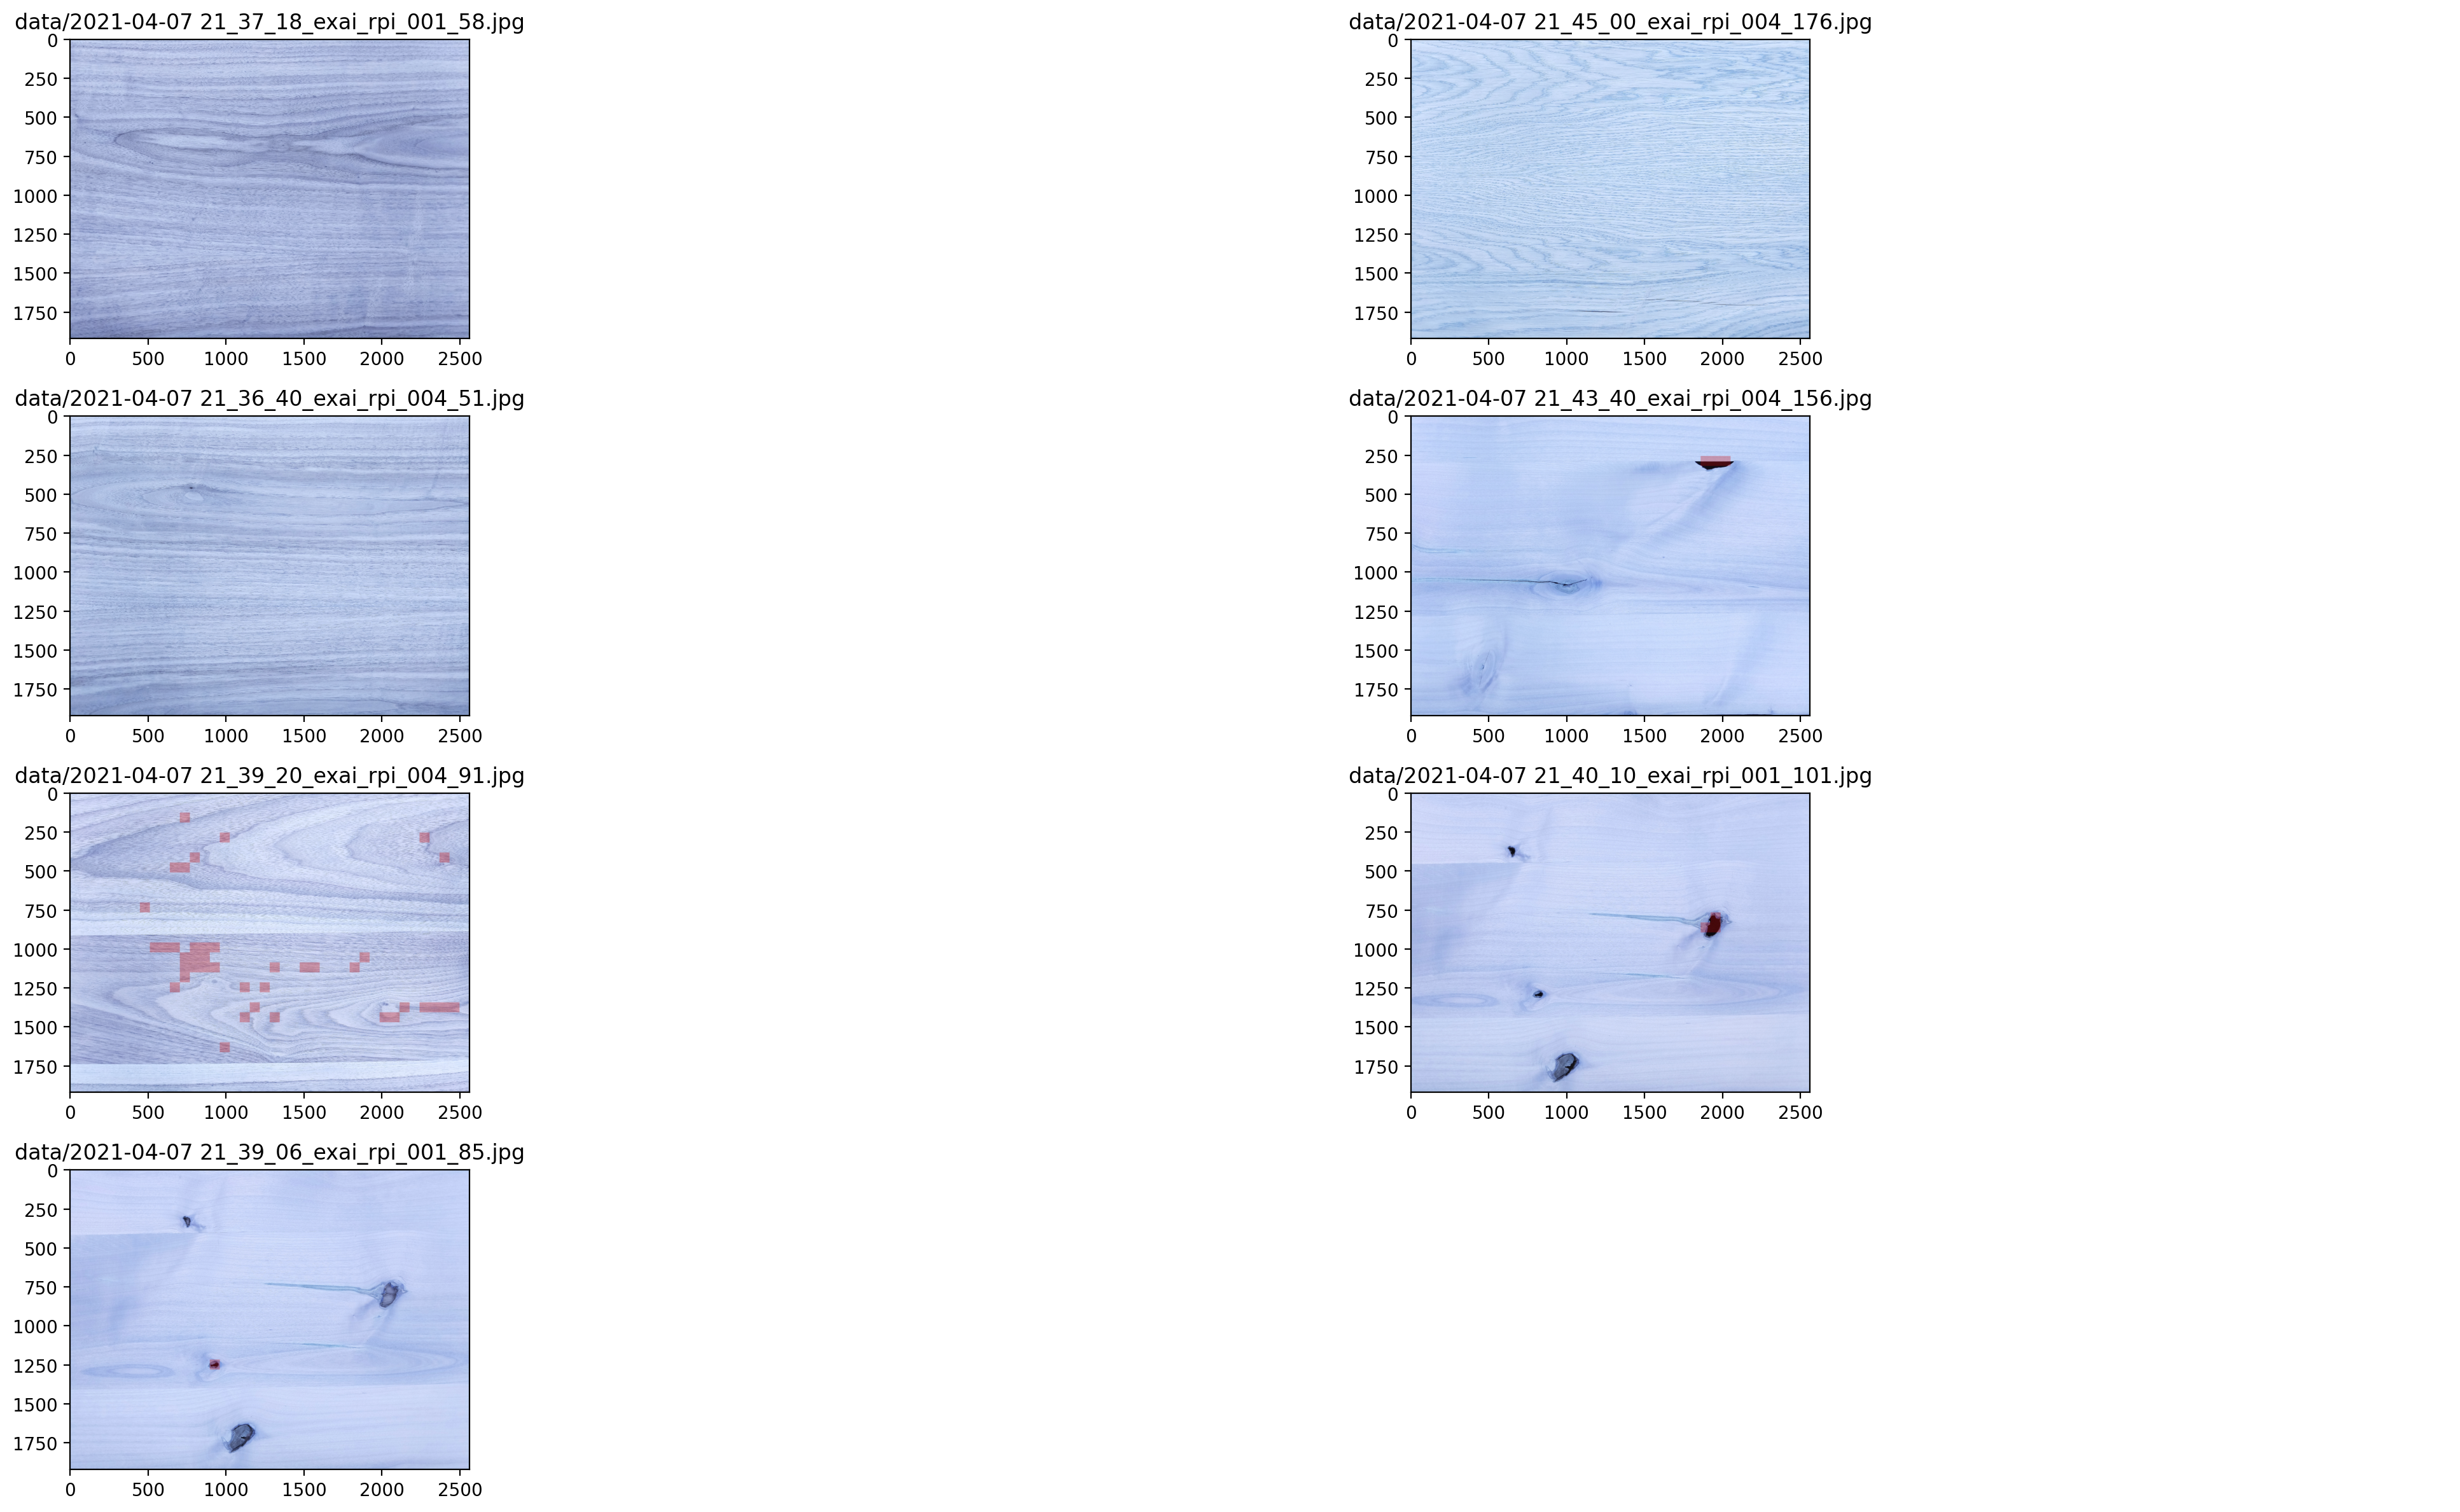

In [10]:
reconstruction_error_thresh = 0.005

f, ax = plt.subplots(4, 2, figsize=(24, 12))
ax = ax.ravel()

for ax_idx, path in enumerate(img_fpaths):
    # Load image as an array
    img = np.array(cv2.imread(path))

    # Resize image
    img_dim = [(img.shape[i] // PATCH_DIM[i]) * PATCH_DIM[i] for i in (1, 0)]
    img = cv2.resize(img, img_dim)

    # Use our function to construct an image with shaded patches labelling anomalies
    img_ = visualise_anomalies(
        image_to_patchify=img,
        patch_dim=PATCH_DIM,
        model=model,
        reconstruction_error_threshold=reconstruction_error_thresh,
        loss_fn=loss_fn,
        transform=transform,
    )

    # Display the image on the axes
    ax[ax_idx].imshow(img_)
    ax[ax_idx].set_title(path)

# Final figure formatting
ax[-1].axis("off")
f.tight_layout()
f.set_dpi(200)